In [27]:
from tensorflow import keras
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

In [28]:
delta = 1
dataset = pd.read_csv("../Datasets/housing.csv")
dataset = dataset.dropna(axis=0)
dataset = dataset.drop('ocean_proximity',axis=1)
dataset = shuffle(dataset)
x_test = dataset.iloc[:2000,:]
x_train = dataset.iloc[2000:,:]
y_train = x_train.pop("median_house_value")
y_test = x_test.pop("median_house_value")

In [29]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = np.expand_dims(y_train,axis=1)
y_test = np.expand_dims(y_test,axis=1)
scaler.fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [30]:
def huber_loss(y_true, y_pred, delta):
    loss = keras.losses.huber(y_true=y_true,y_pred=y_pred, delta=delta)
    return loss

In [31]:
def California_Housing():
  model = Sequential()
  model.add(Dense(20, activation='relu', input_shape=(x_train[0].shape)))
  model.add(Dense(15, activation='relu')) 
  model.add(Dense(1, activation=keras.activations.softsign))
  model.compile(optimizer='SGD', loss=lambda y_true, y_pred:huber_loss(y_true, y_pred, delta), metrics=['mae'])
  return model

In [32]:
epochs = 2500
batch_size = 256

In [33]:
model_const = California_Housing()
K.set_value(model_const.optimizer.learning_rate, 0.01)
history = model_const.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(x_test, y_test))

In [34]:
lrs = [] # to store learning rates
K1 = 0.
model_adapt = California_Housing()
func = K.function([model_adapt.layers[0].input], [model_adapt.layers[-2].output]) # to get the values of activations of second last layer
def lr_schedule(epoch):
    global K1

    Kz = 0.
    
    for i in (range((len(x_train) - 1) // batch_size + 1)):
      start_i = i * batch_size
      end_i = start_i + batch_size
      xb = x_train[start_i:end_i]
      
      tmp = np.array(func([xb]))
      activ = np.linalg.norm(tmp)
      if activ > Kz:
          Kz = activ
    K1 = (1/batch_size)*(Kz)*(1/delta)
    lr = 1 / K1*0.01
    lrs.append(lr)
    return lr

In [35]:
lr_scheduler = LearningRateScheduler(lr_schedule)
history_lalr = model_adapt.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(x_test, y_test), callbacks=[lr_scheduler])

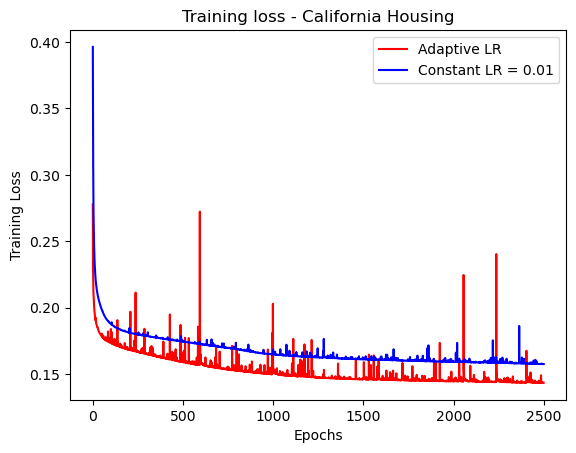

In [36]:
loss_adaptive = history_lalr.history['loss']
loss_constant = history.history['loss']
epochs = range(len(loss_adaptive))

plt.plot(epochs, loss_adaptive, 'r', label='Adaptive LR')
plt.plot(epochs, loss_constant, 'b',label="Constant LR = 0.01")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
# plt.plot(epochs, history_lalr, 'b', label='LALR')
plt.title('Training loss - California Housing')
plt.legend()

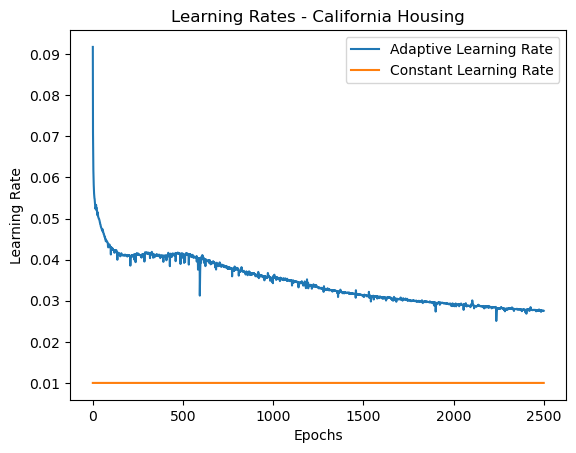

In [37]:
plt.title('Learning Rates - California Housing')
plt.plot(epochs, lrs, label='Adaptive Learning Rate')
plt.plot(epochs, [0.01]*len(epochs), label ='Constant Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()

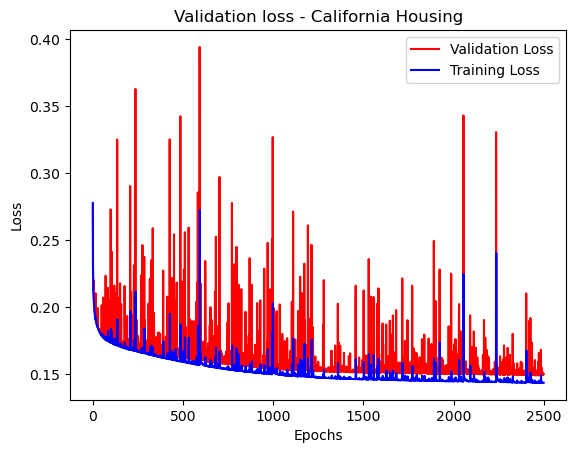

In [39]:
val_loss = history_lalr.history['val_loss']
loss = history_lalr.history['loss']
epochs = range(len(loss_adaptive))

plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.plot(epochs, loss, 'b',label="Training Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.plot(epochs, history_lalr, 'b', label='LALR')
plt.title('Validation loss - California Housing')
plt.legend()